<a href="https://colab.research.google.com/github/DevMachTech/notebooks/blob/master/Bert_huggingface_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.8 MB 5.3 MB/s 
     |████████████████████████████████| 636 kB 41.8 MB/s 
     |████████████████████████████████| 3.3 MB 28.8 MB/s 
     |████████████████████████████████| 895 kB 45.3 MB/s 
     |████████████████████████████████| 52 kB 1.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import transformers

import nltk
import re
import string
from nltk.corpus import stopwords


from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
nltk.download('stopwords')
plt.style.use('seaborn')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.6.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/hate_speech/train.csv", encoding='latin1')
df = df.iloc[:,[3,-1]]

df.head()

,text,label
0,House Dem Aide: We Didnât Even See Comeyâs...,1
1,Ever get the feeling your life circles the rou...,0
2,"Why the Truth Might Get You Fired October 29, ...",1
3,Videos 15 Civilians Killed In Single US Airstr...,1
4,Print \nAn Iranian woman has been sentenced to...,1


In [ ]:
df.columns = ["text", "label"]

In [ ]:
df.describe()

,label
count,20800.000000
mean,0.500625
std,0.500012
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [ ]:
df = df.sample(frac=0.05)
df.describe()
df.isnull().sum()

text     3
label    0
dtype: int64

In [ ]:
df.dropna(inplace=True)
df.isnull().sum()

text     0
label    0
dtype: int64

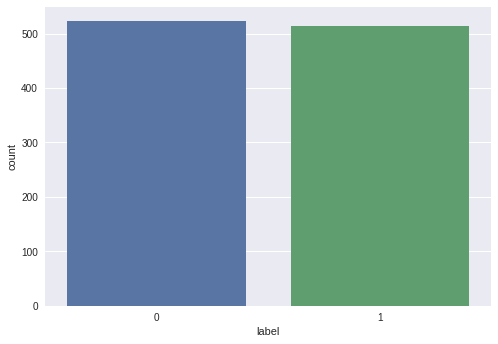

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(x="label", data=df);
plt.show()

In [ ]:
from wordcloud import WordCloud

#plt.figure(figsize = (15,20)) 
#wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(sms[sms.type == "bs"].text))
#plt.imshow(wc , interpolation = 'bilinear')
#plt.savefig('bs_class.png')

In [ ]:
#plt.figure(figsize = (15,20)) 
#wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(sms[sms.type == "bias"].text))
#plt.imshow(wc , interpolation = 'bilinear')
#plt.savefig('biass_class.png')

** Text cleanning: **
- remove strange characters
- remove URLs (they doesn't tell us pretty much)
- replace usernames for "@" character
- remove line breaks

In [ ]:
dataf = df

In [ ]:
dataf['text']=dataf['text'].apply(str)

In [ ]:
def clean_text(text):
    #Remove emojis and special chars
    clean=text
    #reg = re.compile('\\.+?(?=\B|$)')
    #clean = text.apply(lambda r: re.sub(reg, string=r, repl=''))
    #reg = re.compile('\x89Û_')
    #clean = clean.apply(lambda r: re.sub(reg, string=r, repl=' '))
    reg = re.compile('\&amp')
    clean = clean.apply(lambda r: re.sub(reg, string=r, repl='&'))
    reg = re.compile('\\n')
    clean = clean.apply(lambda r: re.sub(reg, string=r, repl=' '))

    #Remove hashtag symbol (#)
    #clean = clean.apply(lambda r: r.replace('#', ''))

    #Remove user names
    reg = re.compile('@[a-zA-Z0-9\_]+')
    clean = clean.apply(lambda r: re.sub(reg, string=r, repl='@'))

    #Remove URLs
    reg = re.compile('https?\S+(?=\s|$)')
    clean = clean.apply(lambda r: re.sub(reg, string=r, repl='www'))

    #Lowercase
    #clean = clean.apply(lambda r: r.lower())
    return clean

In [ ]:
dataf['clean'] = clean_text(dataf['text'])
#dataf_test['clean'] = clean_text(dataf_test['text'])

In [ ]:
dataf.head(3)

,text,label,clean
5033,Judith Katherine Dunning had been waiting anxi...,0,Judith Katherine Dunning had been waiting anxi...
14739,White House press secretary Sean Spicer reacte...,0,White House press secretary Sean Spicer reacte...
3770,Posters calling on Donald Trump to âDeport F...,0,Posters calling on Donald Trump to âDeport F...


In [ ]:
# This is the identifier of the model. The library need this ID to download the weights and initialize the architecture
# here is all the supported ones:
# https://huggingface.co/transformers/pretrained_models.html
bert_model = 'distilbert-base-uncased'
bert_tokenizer = transformers.DistilBertTokenizer.from_pretrained(bert_model)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
def create_bert(mname):
    """ Creates the model. It is composed of the BErtt main block and then
    a classification head its added
    """
    # Define token ids as inputs
    word_inputs = tf.keras.Input(shape=(120,), name='word_inputs', dtype='int32')

    # Call XLNet model
    bert = transformers.TFDistilBertModel.from_pretrained(mname)
    bert_encodings = bert(word_inputs)[0]

    # CLASSIFICATION HEAD 
    # Collect last step from last hidden state (CLS)
    doc_encoding = tf.squeeze(bert_encodings[:, -1:, :], axis=1)
    # Apply dropout for regularization
    doc_encoding = tf.keras.layers.Dropout(.1)(doc_encoding)
    # Final output 
    outputs = tf.keras.layers.Dense(1, activation='sigmoid', name='outputs')(doc_encoding)

    # Compile model
    model = tf.keras.Model(inputs=[word_inputs], outputs=[outputs])
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=2e-5), loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

    return model

In [ ]:
bert = create_bert(bert_model)

Downloading:   0%|          | 0.00/363M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'vocab_projector', 'vocab_transform', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experi

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
bert.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_inputs (InputLayer)     [(None, 120)]             0         
_________________________________________________________________
tf_distil_bert_model (TFDist TFBaseModelOutput(last_hi 66362880  
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 1, 768)            0         
_________________________________________________________________
tf.compat.v1.squeeze (TFOpLa (None, 768)               0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 768)               0         
_________________________________________________________________
outputs (Dense)              (None, 1)                 769       
Total params: 66,363,649
Trainable params: 66,363,649
Non-trainable params: 0
_________________________________________________

Clean and split the data

In [ ]:
texts = dataf['clean']
labels = dataf['label']


X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.15, random_state=196)

In [ ]:
def get_inputs(texts, tokenizer, max_len=120):
    """ Gets tensors from text using the tokenizer provided"""
    inps = [tokenizer.encode_plus(t, max_length=max_len, pad_to_max_length=True, add_special_tokens=True) for t in texts]
    inp_tok = np.array([a['input_ids'] for a in inps])
    ids = np.array([a['attention_mask'] for a in inps])
    #segments = np.array([a['token_type_ids'] for a in inps])
    return inp_tok, ids

def warmup(epoch, lr):
    """Used for increasing the learning rate slowly, this tends to achieve better convergence.
    However, as we are finetuning for few epoch it's not crucial.
    """
    return max(lr +1e-6, 2e-5)

def plot_metrics(pred, true_labels):
    """Plots a ROC curve with the accuracy and the AUC"""
    acc = accuracy_score(true_labels, np.array(pred.flatten() >= .5, dtype='int'))
    fpr, tpr, thresholds = roc_curve(true_labels, pred)
    auc = roc_auc_score(true_labels, pred)

    fig, ax = plt.subplots(1, figsize=(8,8))
    ax.plot(fpr, tpr, color='red')
    ax.plot([0,1], [0,1], color='black', linestyle='--')
    ax.set_title(f"AUC: {auc}\nACC: {acc}");
    return fig

Create the input data (tensors)

In [ ]:
inp_tok, ids = get_inputs(X_train, bert_tokenizer)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2204: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
import torch
input_ids = torch.tensor(ids)
input_tokens = torch.tensor(inp_tok)

In [ ]:
all_inputs = tf.concat(
    [input_tokens, input_ids], axis=1, name='concat'
)

In [ ]:
all_inputs[1]

<tf.Tensor: shape=(240,), dtype=int64, numpy=
array([  101, 15536,  3211, 19738,  5705, 19195,  7207,  2001,  4012,
       24759, 28775,  2102,  1999,  1996,  4028,  1997,  6059,  8799,
        1011,  1996, 20116,  2015,  6267,  2023,  2035, 29107,  3508,
        2176,  2086,  3283,  1996,  2397,  6059,  8799, 15536,  3211,
       19738,  5705,  2003,  2055,  2000, 12210,  1996,  2466,  2008,
        1996,  2691,  3168,  2265,  2409,  1018,  2086,  3283,  1999,
        2008,  6059,  8799,  2001,  2275,  2039,  2000,  3280,  2138,
        2010,  3441,  1997,  3282,  1011,  2770,  1010,  2775, 11626,
        1998,  4319,  1011,  2770,  2006,  6852,  1997,  1996,  9915,
        1999,  2344,  2000,  5326,  6939,  2689,  1999, 12917,  2478,
       15554,  6787,  2011,  2122,  6206,  3450,  1010,  2020, 24325,
        2041,  1998,  2009,  2001,  2069,  1037,  2261,  2706,  2127,
        1996,  2602,  1012,  3525,  1010,  6059,  8799,  2018,  2000,
        2022, 25030,   102,     1,     1,   

### Training

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4, min_delta=0.02, restore_best_weights=True),
    tf.keras.callbacks.LearningRateScheduler(warmup, verbose=0),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=1e-6, patience=2, verbose=0, mode='auto', min_delta=0.001, cooldown=0, min_lr=1e-6)
]

In [ ]:
hist = bert.fit(x=inp_tok, y=y_train, epochs=2, batch_size=32, validation_split=.15, callbacks=callbacks)

Epoch 1/2
24/24 [==============================] - 32s 883ms/step - loss: 0.5384 - accuracy: 0.7112 - precision: 0.7353 - recall: 0.6649 - val_loss: 0.3974 - val_accuracy: 0.8421 - val_precision: 0.8871 - val_recall: 0.7971
Epoch 2/2
24/24 [==============================] - 19s 789ms/step - loss: 0.2912 - accuracy: 0.8757 - precision: 0.8942 - recall: 0.8537 - val_loss: 0.2615 - val_accuracy: 0.8722 - val_precision: 0.9333 - val_recall: 0.8116


### Testing

In [ ]:
inp_tok, ids = get_inputs(X_test, bert_tokenizer)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2204: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
import torch
input_ids = torch.tensor(ids)
input_tokens = torch.tensor(inp_tok)

In [ ]:
all_inputs_test = tf.concat(
    [input_tokens, input_ids], axis=1, name='concat'
)

In [ ]:
all_inputs_test[1]

<tf.Tensor: shape=(240,), dtype=int64, numpy=
array([  101,  2047,  2188,  4341,  1011,  4389, 18981,  2063,  3328,
        2058,  1037, 27370,  8399,  2011,  3389, 17969,  1012,  1996,
        6236,  2533,  2988,  2651,  2008,  4341,  1997,  4397,  2328,
        5014,  6866,  1037, 12348,  2135, 10426,  3204,  2000,  3204,
        3623,  1997,  1017,  1012,  1015,  1003,  2000,  2019,  3296,
        3550,  3446,  1997,  5354,  2509,  1010,  2199,  1012,  1996,
        2533,  8001,  1996,  2257, 17653,  2193,  2091,  2011,  1019,
        1012,  1020,  1003,  2013,  3438,  2683,  1010,  2199,  2000,
        5401,  2629,  1010,  2199,  1012,  2302,  2008, 13921,  1996,
       17653,  2193,  2023,  3204,  2052,  2031,  2042,  2091,  2011,
        1016,  1012,  1021,  1003,  1012,  4474,  1010,  4474,  1012,
        7065,  5562,  1010,  7065,  5562,  1012,   102,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     1,     1,   

In [ ]:
preds = bert.predict(inp_tok, verbose=True)

5/5 [==============================] - 3s 247ms/step


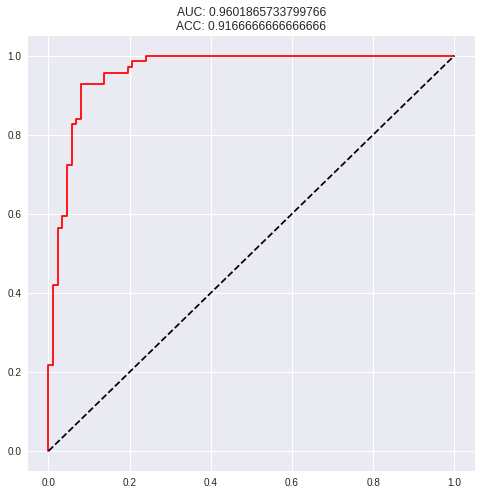

In [ ]:
plot_metrics(preds, y_test);

### Why the fails?

Studying the examples our NN failed to classify could give us some hints to improve

In [ ]:
pred_analysis_df = pd.DataFrame({'text':X_test.values, 'pred':preds.flatten(), 'real':y_test})
pred_analysis_df['rounded'] = np.array(pred_analysis_df['pred'] > 0.5, dtype='int')
diff = pred_analysis_df[pred_analysis_df['real'] != pred_analysis_df['rounded']]

In [ ]:
#change to see other examples
idx = 2

text, real, pred = diff.iloc[idx, [0,2,3]]
print(text)
print("PRED: " + str(pred))
print("REAL: " + str(real))

The percentage of people attending church in Poland rose in 2015 from 39. 1 per cent to 39. 8 per cent, bucking a trend of decline across the rest of Europe. [Figures from the Institute of Statistics of the Catholic Church in Poland show the percentage of people receiving Holy Communion in the former Communist country also rose from 16. 3 per cent to 17 per cent in the same year.  Meanwhile, the number of Catholic priests in the country also rose to a record 20, 800 in figures that suggest the country is rejecting the secular liberalism of institutions such as the European Union (EU) and embracing its traditional Christian culture. Religion website Zenit also says there was a âmassiveâ reception of the Sacraments in parishes across the country in 2015, with 369, 000 baptism, 360, 000 confirmations, 270, 000 first communions and 134, 000 marriages. Poland is showing signs of being increasingly resistant to globalist liberalism, adopting an ever more culturally conservative approach 